# Lab 4 - Dealing with common issues regarding linear regressions 

In this lab, we'll be analyzing the following:
1. Interpreting a multivariate linear regression
2. Examining multicollinearity & Variance Inflation Factors
3. Examining homoscedasticity
4. Doing log transformations of a variable
5. Accounting for non-linear effects (eg - age)

In [27]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor ### VIF package
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.discrete.discrete_model import Logit
from scipy.stats.mstats import zscore

### Load the data

In [13]:
raw = pd.read_csv ('data.csv')
raw.head(2)

,Unnamed: 0,id,price_000,apt,floor,age_0_10,age_10_20,age_20_more,num_room,num_bath,...,pcnt_com,pcnt_insti,pcnt_vacant,pcn_green,homicides,house,ses_bin,lnprice,price_hi,year
0,0,40003,60000,1,5,1,0,0,3,2,...,0.00,0.49,0.0,1.74,39.92,0,0,11.0021,0,2001
1,1,40007,140000,0,0,0,1,0,4,4,...,15.41,1.32,0.0,0.54,46.00,1,0,11.8494,1,2002


Create a copy with only the variables of interest

In [16]:
var_list = ['price_000','pop_dens','ses','house','area_m2','num_bath','pcn_green','homicides', 'year']
data = raw[var_list].copy()
data.head(2)

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year
0,60000,830.78,4,0,70,2,1.74,39.92,2001
1,140000,826.75,4,1,257,4,0.54,46.00,2002


Let's redefine the socieconomic status - this is the same process we did in lab 3!

In [17]:
#Recode SES
data['high_ses'] = np.where(data['ses']>=5, 1, 0)  #Create Dummy Variable

Now, let's create dummy variables for the year the property was sold. There are 6 unique years, which means we need to create 5 new columns, each for a year of interest (minus the base), with values of ones and zeros. This is a long process, but python (for once!) can make this easier for us.

In [25]:
dummies = pd.get_dummies(data['year'], prefix = 'yr') ### This will give you all the dummies, but we need to drop one!
dummies = dummies.drop(columns = ['yr_2006']) ### We dropped the year 2006

data = pd.concat([data, dummies], axis = 1)
data

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005
0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0
1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0
2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0
3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0
4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3971,480000,884.63,6,0,291,5,1.02,234.00,2005,1,0,0,0,0,1
3972,500000,884.63,6,0,204,3,1.02,234.00,2006,1,0,0,0,0,0
3973,564425,374.17,3,0,145,2,0.06,234.00,2001,0,1,0,0,0,0
3974,699800,320.50,6,0,175,3,1.90,234.00,2004,1,0,0,0,1,0


### Estimate a multivariate linear regression model

We'll be running the same multivariate regression model that we used for lab 3

In [26]:
#Define Independent Variables
ind_var = ['ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 'homicides'] 

#Generally, first variable is your 'key explanatory variable', followed by your control variables
x = data[ind_var].assign(Intercept = 1) #Independent Variables
y = data['price_000'] #Dependent Variable

model = sm.OLS(y, x).fit() ### Let's save the results under model. This will be useful for other functions below.
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.501     
Dependent Variable:   price_000         AIC:                 97841.9134
Date:                 2020-02-18 09:46  BIC:                 97885.9296
No. Observations:     3976              Log-Likelihood:      -48914.   
Df Model:             6                 F-statistic:         666.9     
Df Residuals:         3969              Prob (F-statistic):  0.00      
R-squared:            0.502             Scale:               2.8440e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
ses        23692.5176 1216.8735  19.4700 0.0000  21306.7618  26078.2734
house     -27895.8575 2501.4712 -11.1518 0.0000 -32800.1465 -22991.5684
area_m2      569.3990   14.6571  38.8480 0.0000    540.6628    598.1352
num_bath   10485.8862  971.2311  10.7965 0.0000   8581.7276  12390.0448
pcn_green    -99.2132  119.5193  -0.8301 0.4065   -333.5382    135.1118
homicides     43.3831   17.0906   2.5384 0.0112      9.8759     76.8903
Intercept -76643.5924 5063.0661 -15.1378 0.0000 -86570.0466 -66717.1381
-----------------------------------------------------------------------
Omnibus:              3250.518       Durbin-Watson:          0.846     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       132799.568
Skew:                 3.619          Prob(JB):               0.000     
Kurtosis:             30.372         Condition No.:          1028      
=======================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

Now, let's run the same regression, but let's standardize all the variables!

In [33]:
ind_var = ['ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 'homicides']
x_zscore = data[ind_var].apply(zscore).assign(Intercept = 1)
x_zscore.head(5)

,ses,house,area_m2,num_bath,pcn_green,homicides,Intercept
0,0.637882,-0.691424,-0.599922,-0.200787,-0.207483,-0.838889,1
1,0.637882,1.446291,1.571573,1.732213,-0.359941,-0.733409,1
2,0.637882,-0.691424,-0.077369,1.732213,-0.231622,-0.735664,1
3,0.637882,1.446291,1.722533,1.732213,-0.227811,-0.735491,1
4,0.637882,1.446291,1.699308,-0.200787,-0.377728,-0.733409,1


In [34]:
model = sm.OLS(y, x_zscore).fit() ### Let's save the results under model. This will be useful for other functions below.
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.501     
Dependent Variable:   price_000         AIC:                 97841.9134
Date:                 2020-02-18 09:53  BIC:                 97885.9296
No. Observations:     3976              Log-Likelihood:      -48914.   
Df Model:             6                 F-statistic:         666.9     
Df Residuals:         3969              Prob (F-statistic):  0.00      
R-squared:            0.502             Scale:               2.8440e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
ses        18048.1090  926.9705  19.4700 0.0000  16230.7260  19865.4921
house     -13049.3826 1170.1614 -11.1518 0.0000 -15343.5563 -10755.2088
area_m2    49034.2471 1262.2083  38.8480 0.0000  46559.6097  51508.8845
num_bath   10849.3381 1004.8950  10.7965 0.0000   8879.1793  12819.4968
pcn_green   -780.9053  940.7346  -0.8301 0.4065  -2625.2736   1063.4631
homicides   2500.6565  985.1252   2.5384 0.0112    569.2576   4432.0554
Intercept  93511.0455  845.7550 110.5652 0.0000  91852.8905  95169.2005
-----------------------------------------------------------------------
Omnibus:              3250.518       Durbin-Watson:          0.846     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       132799.568
Skew:                 3.619          Prob(JB):               0.000     
Kurtosis:             30.372         Condition No.:          3         
=======================================================================

"""

### Let's examine multicolinearity!

First, let's examine the correlation matrix. If we take price to be our dependent variable - which of these variables will have a multicollinearity effect in our regression?

In [37]:
data[var_list].corr()

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year
price_000,1.000000,0.025395,0.332310,0.272182,0.632867,0.438951,-0.024504,-0.140996,0.027371
pop_dens,0.025395,1.000000,-0.066464,0.186380,0.169518,0.085829,-0.030906,0.122644,-0.148788
ses,0.332310,-0.066464,1.000000,-0.147592,0.101272,0.080532,0.052955,-0.272214,-0.016840
house,0.272182,0.186380,-0.147592,1.000000,0.651771,0.391207,-0.071164,0.002256,-0.171000
area_m2,0.632867,0.169518,0.101272,0.651771,1.000000,0.530402,-0.081659,-0.155758,-0.131592
num_bath,0.438951,0.085829,0.080532,0.391207,0.530402,1.000000,0.004428,-0.023408,-0.115059
pcn_green,-0.024504,-0.030906,0.052955,-0.071164,-0.081659,0.004428,1.000000,0.400809,0.109888
homicides,-0.140996,0.122644,-0.272214,0.002256,-0.155758,-0.023408,0.400809,1.000000,0.030248
year,0.027371,-0.148788,-0.016840,-0.171000,-0.131592,-0.115059,0.109888,0.030248,1.000000


Now, let's use the Variance Inflation Factor (VIF)

In [38]:
vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])] #have to include intercept
vif

[1.2012757242368917,
 1.9142662712925385,
 2.227270076371359,
 1.4117317371948093,
 1.2372146659377956,
 1.3567308654658161,
 35.8375267326744]

Wow! What are these numbers?! What is going on? Let's add some labels to the data.

In [39]:
pd.Series(vif, index=x.columns)

ses           1.201276
house         1.914266
area_m2       2.227270
num_bath      1.411732
pcn_green     1.237215
homicides     1.356731
Intercept    35.837527
dtype: float64

If you go to the Appendix, there is a step by step explanation of the variance_inflation_factor function and all its inputs. This is confusing, we know. We wish it were simpler, we really do. The good thing is, you'll have it coded forever! The bad one is, well... See above. If any of this is still unclear, or your eyes are glazing over the above, please come to office hours. We'll do our best to walk you through it, as many times as you might need it.

### Now, let's do some homoscedasticity examination!

In [40]:
def homoscedasticity_plots(observed, prediction, residuals):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ### Figure 1
    x1 = prediction
    y1 = residuals
    ### Figure 2
    x2 = observed
    y2 = residuals

    ### Creates title for overall figure
    plt.suptitle('Residuals vs. observed and fitted data')

    ### Creates first plot
    ax1.scatter(x1, y1)
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ### Formats axis number to include thousands separator
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))

    ### Creates second plot
    ax2.scatter(x2, y2) ### We can change the color and marker type
    ax2.set_xlabel('Observed Values')

    ### Formats axis number to include thousands separator
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))

    plt.show()

Remember we saved the results of the linear regression under the model variable above

model = sm.OLS(y, x).fit()

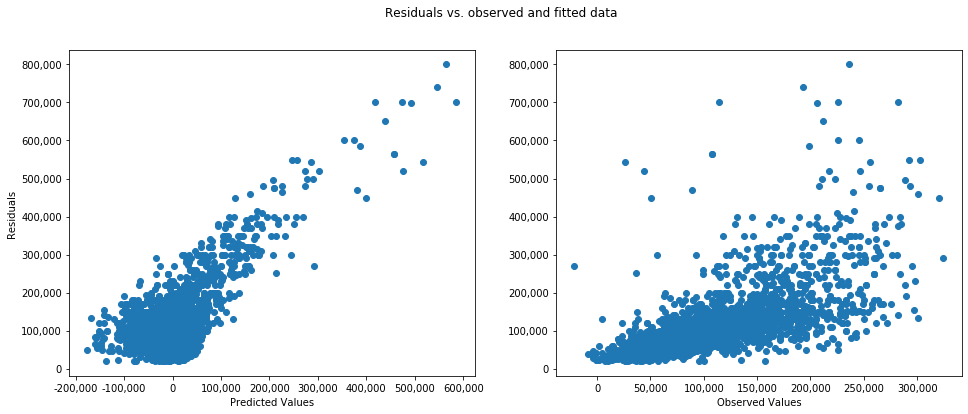

In [41]:
observed = data['price_000'] ### These are the observed values of prices
prediction = model.predict() ### These are the price predictions using the same x values as the data input
residuals = model.resid ### These are the residuals of the prediction model
    
homoscedasticity_plots(prediction, residuals, observed)

We can also test whether there is heteroscedasticiy by using the Breusch Pagan test. Look at the p_values!

In [42]:
het_breuschpagan(residuals, x.values)

(281.7031098568608,
 6.785888440448385e-58,
 50.44169776054281,
 4.643752433226735e-60)

### Now, let's do some log-transformations!

•	Log transforming an independent variable without zeroes and with zeroes

First, let's examine some of the continous variables in our database. We are going to plot them against price. Which of these look non-linear to you?

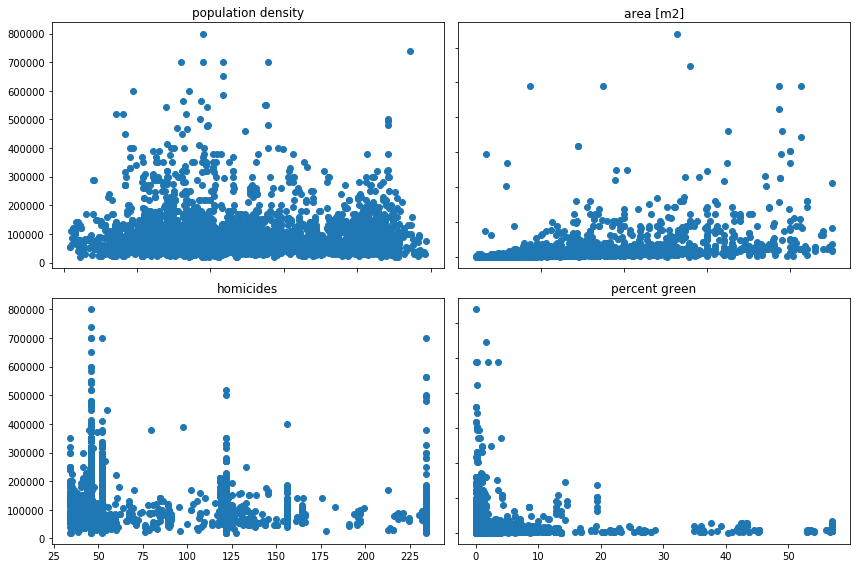

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
y = data['price_000']

x = data['pop_dens']
ax1.scatter(x, y)
ax1.set_title('population density')

x = data['area_m2']
ax2.scatter(x, y**2)
ax2.set_title('area [m2]')

x = data['homicides']
ax3.scatter(x, y)
ax3.set_title('homicides')

x = data['pcn_green']
ax4.scatter(x, y**2)
ax4.set_title('percent green')

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()

Let's transform the percentage of green!

In [51]:
# What happens if we do this?
data['pcn_green_log'] = np.log(data['pcn_green'])

The log of 0 is undefined in the log function (it tends towards $-\infty$), so we need to scale the variable

In [52]:
# Let's try this instead!
data['pcn_green_log'] = np.log(data['pcn_green']+1)

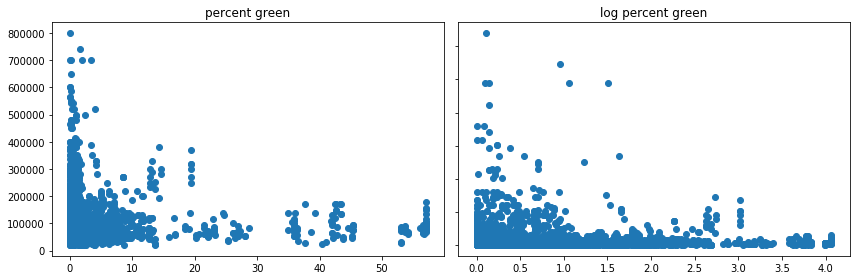

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
y = data['price_000']

x = data['pcn_green']
ax1.scatter(x, y)
ax1.set_title('percent green')

x = data['pcn_green_log']
ax2.scatter(x, y**2)
ax2.set_title('log percent green')

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()

## Let's do a logit regression!

Remember - logit regression are used when the DEPENDENT variable is a dummy variable (0 or 1). In this case, we are going to transform our price into a dummy variable, using the median as cutoff. We did this during lab 2!

In [54]:
price_median = data['price_000'].median()
print(price_median)

data['high_price'] = np.where(data['price_000']>price_median, 1, 0)
data.head(2)

72000.0


,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,homicides,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,pcn_green_log,high_price
0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,1.007958,0
1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0.431782,1


In [55]:
y = data['high_price']
x = data[ind_var].assign(Intercept = 1) #Independent Variables

x.head(2)

,ses,house,area_m2,num_bath,pcn_green,homicides,Intercept
0,4,0,70,2,1.74,39.92,1
1,4,1,257,4,0.54,46.00,1


In [56]:
logit_model = Logit(y, x).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.409520
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             high_price   No. Observations:                 3976
Model:                          Logit   Df Residuals:                     3969
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Feb 2020   Pseudo R-squ.:                  0.4092
Time:                        10:05:49   Log-Likelihood:                -1628.3
converged:                       True   LL-Null:                       -2755.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ses            1.0513      0.074     14.181      0.000       0.906       1.197
house         -0.1641      0.133     -1.238      0.216      -0.424       0.096
area_m2        0.0273      0.001     20.150      0.000       0.025       0.030
num_bath       0.5504      0.055     10.044      0.000       0.443       0.658
pcn_green      0.0280      0.006      5.029      0.000       0.017       0.039
homicides     -0.0019      0.001     -1.989      0.047      -0.004   -2.74e-05
Intercept     -7.6072      0.347    -21.953      0.000      -8.286      -6.928
==============================================================================
"""

In [64]:
### Odds ratio

params = logit_model.params
conf = logit_model.conf_int()

conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '2.5%', '97.5%']
print(np.exp(conf))

           Odds Ratio      2.5%     97.5%
ses          2.474423  3.308899  2.861401
house        0.654384  1.100551  0.848636
area_m2      1.024968  1.030430  1.027695
num_bath     1.557394  1.930606  1.733988
pcn_green    1.017226  1.039660  1.028382
homicides    0.996282  0.999973  0.998125
Intercept    0.000252  0.000980  0.000497


### Appendix

##### VIF - Let's unpack this

In [28]:
# We created a list of independent variables
ind_var = ['ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 'homicides'] 

# We assigned them to the variable x, and included a column of ones (the intercept)
x = data[ind_var].assign(Intercept = 1) #Independent Variables

x.head(5)

,ses,house,area_m2,num_bath,pcn_green,homicides,Intercept
0,4,0,70,2,1.74,39.92,1
1,4,1,257,4,0.54,46.00,1
2,4,0,115,4,1.55,45.87,1
3,4,1,270,4,1.58,45.88,1
4,4,1,268,2,0.40,46.00,1


Take a look at the `variance_inflaction_factor function`. What does it require as inputs? Use the `shit`+`tab` command to examine the documentation or run the next line of code.

In [30]:
variance_inflation_factor?

So we can see that the function needs 2 things:
    1. the values defined as x above
    2. the variable (column number) for which you want to run the VIF

However, what happens when I run the following? Yes - it errors out. Why?

In [34]:
variance_inflation_factor (x, 0)

TypeError: '(slice(None, None, None), 0)' is an invalid key

Turns out, x is a dataframe and the VIF function doesn't know what a dataframe is. It wants the values of the dataframe in an array format. Look below - the numbers are the same, but the format is different.

In [38]:
x.head(2)

,ses,house,area_m2,num_bath,pcn_green,homicides,Intercept
0,4,0,70,2,1.74,39.92,1
1,4,1,257,4,0.54,46.00,1


In [42]:
x.values[0:2]

array([[  4.  ,   0.  ,  70.  ,   2.  ,   1.74,  39.92,   1.  ],
       [  4.  ,   1.  , 257.  ,   4.  ,   0.54,  46.  ,   1.  ]])

Now, let's examine the second parameter - the column number. If I input the column number manually, I will get one result. Play around with the second parameter and see if the IFV changes. What happens if you choose a number higher that 6? Why?

In [46]:
variance_inflation_factor(x.values, 5)

1.3567308654658161

In [47]:
variance_inflation_factor(x.values, 10)

IndexError: index 10 is out of bounds for axis 1 with size 7

That's right! There are only 7 columns and remember, the first column is assigned an index of 0. Therefore, if you use a number higher than 6, it will error out.

Now that we have the parameters of the function, the second part of this line of code is the "list logic". This is the similar to running a for loop, but coded in a single line. What we are saying is: run the `variance_inflation_function` for every value of `i` in the range 0 - 6. How does it know when to stop? It's using the `shape` function.

In [51]:
x.shape # Outputs the shape of the dataframe
x.shape[0] #Accesses the fist number - number of rows
x.shape[1] #Accesses the second number - number of columns
print(x.shape[0])
print(x.shape[1])

3976
7


Now, we can run the function and see the results

In [52]:
[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

[1.2012757242368917,
 1.9142662712925385,
 2.227270076371359,
 1.4117317371948093,
 1.2372146659377956,
 1.3567308654658161,
 35.8375267326744]

Add the column names as the series index (or row name)!

In [54]:
pd.Series(vif, index=x.columns)

ses           1.201276
house         1.914266
area_m2       2.227270
num_bath      1.411732
pcn_green     1.237215
homicides     1.356731
Intercept    35.837527
dtype: float64

In [ ]:
raw['year'] = np.where(raw['yr_2001']==1, '2001',
                        np.where(raw['yr_2002']==1, '2002',
                                np.where(raw['yr_2003']==1, '2003',
                                        np.where(raw['yr_2004']==1, '2004',
                                                np.where(raw['yr_2005']==1, '2005',
                                                        np.where(raw['yr_2006']==1, '2006', ''))))))

raw = raw.drop(columns = ['yr_2001', 'yr_2002', 'yr_2003', 'yr_2004', 'yr_2005', 'yr_2006'])

raw.to_csv('data.csv')